For this experiment we use the BERT-Emotions-Classifier which can be accessed here: https://huggingface.co/ayoubkirouane/BERT-Emotions-Classifier

# Important
To be able to run this code, the above mentioned repository needs to be cloned. The path to the repository has to be adapted in the code below. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load data from CSV files
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# load the pre-trained tokenizer and model
model_name = "../BERT-Emotions-Classifier" # change path to model if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# define the emotion labels corresponding to the model's outputs
class_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

def classify_emotions(text):
    # tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # perform emotion classification
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # apply sigmoid to get probabilities for multi-label classification
    probabilities = torch.sigmoid(logits).squeeze().tolist()

    # and finally pair each label with its corresponding score
    results = [{'label': label, 'score': score} for label, score in zip(class_labels, probabilities)]

    return [results]  # then we return a list containing the results list



In [20]:
# below you see an example on how the usage and output looks like

# input text
text = "I like you. I love you."

# get emotion classification
output = classify_emotions(text)

print(output)

[[{'label': 'anger', 'score': 0.01838717795908451}, {'label': 'anticipation', 'score': 0.05328797176480293}, {'label': 'disgust', 'score': 0.019515816122293472}, {'label': 'fear', 'score': 0.04306893050670624}, {'label': 'joy', 'score': 0.9890292882919312}, {'label': 'love', 'score': 0.936290979385376}, {'label': 'optimism', 'score': 0.920278787612915}, {'label': 'pessimism', 'score': 0.021986450999975204}, {'label': 'sadness', 'score': 0.0355835035443306}, {'label': 'surprise', 'score': 0.0395362451672554}, {'label': 'trust', 'score': 0.34443098306655884}]]


In [21]:
# install the emoji package for demojize
!pip3 install emoji

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
import re

# emoji patterns
emoji_pattern = re.compile(
    "["  
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # geometric shapes
    "\U0001F800-\U0001F8FF"  # supplemental arrows
    "\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
    "\U0001FA00-\U0001FA6F"  # chess symbols
    "\U0001FA70-\U0001FAFF"  # symbols and pictographs
    "\U00002702-\U000027B0"  # dingbats
    "\U000024C2-\U0001F251"  # enclosed characters
    "]", flags=re.UNICODE)


# function to clean tweets: replace mentions, URLs, hashtags, remove multiple spaces, and lowercase
def remove_clean_tweet(tweet):
    tweet = tweet.lower()  # convert tweet to lowercase
    # remove hashtags 
    tweet = re.sub(r'#\S+', ' ', tweet)
    # remove URLs
    tweet = re.sub(r'http[s]?://\S+', ' ', tweet)  # for URLs starting with http:// or https://
    tweet = re.sub(r'www\S+', ' ', tweet)  # for URLs starting with www
    # remove mentions
    tweet = re.sub(r'@\S+', ' ', tweet)  # for mentions like @username
    # add whitespace after emojis
    tweet = re.sub(emoji_pattern, r'\g<0> ', tweet)
    # remove retweets
    tweet = re.sub('rt', ' ', tweet)
    # remove extra spaces and leading/trailing spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # replace multiple spaces with a single space
    return tweet

# limit to the first 300 rows for train_df and first 100 rows for test_df
train_df = train_df.iloc[:300]
test_df = test_df.iloc[:100]

# preprocess and clean the tweets
train_df['removed_text'] = train_df['tweet'].apply(remove_clean_tweet)
test_df['removed_text'] = test_df['tweet'].apply(remove_clean_tweet)


/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_8218/2005935594.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['removed_text'] = train_df['tweet'].apply(remove_clean_tweet)


In [23]:
# here we convert emojis to text
import emoji

# apply emoji.demojize to the "text" column which transcribes the emojis
train_df['cleaned_text'] = train_df['removed_text'].apply(emoji.demojize)
test_df['cleaned_text'] = test_df['removed_text'].apply(emoji.demojize)
train_df.head()

,tweet,label,gender,removed_text,cleaned_text
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...
2,Check out these awesome cooking t-shirts &amp;...,bot,bot,check out these awesome cooking t-shi s &amp; ...,check out these awesome cooking t-shi s &amp; ...
3,YEWWinfo Tiny Nanoparticles to Treat a Huge Pr...,bot,bot,yewwinfo tiny nanopa icles to treat a huge pro...,yewwinfo tiny nanopa icles to treat a huge pro...
4,Sr. Project Manager Water / Wastewater Enginee...,bot,bot,sr. project manager water / wastewater enginee...,sr. project manager water / wastewater enginee...


In [24]:
# apply the classify_emotions function to the "cleaned_text" column
train_df["emotion_scores"] = train_df["cleaned_text"].apply(classify_emotions)
test_df["emotion_scores"] = test_df["cleaned_text"].apply(classify_emotions)

train_df

,tweet,label,gender,removed_text,cleaned_text,emotion_scores
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...,"[[{'label': 'anger', 'score': 0.98498278856277..."
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...,"[[{'label': 'anger', 'score': 0.35027897357940..."
2,Check out these awesome cooking t-shirts &amp;...,bot,bot,check out these awesome cooking t-shi s &amp; ...,check out these awesome cooking t-shi s &amp; ...,"[[{'label': 'anger', 'score': 0.22659523785114..."
3,YEWWinfo Tiny Nanoparticles to Treat a Huge Pr...,bot,bot,yewwinfo tiny nanopa icles to treat a huge pro...,yewwinfo tiny nanopa icles to treat a huge pro...,"[[{'label': 'anger', 'score': 0.30082523822784..."
4,Sr. Project Manager Water / Wastewater Enginee...,bot,bot,sr. project manager water / wastewater enginee...,sr. project manager water / wastewater enginee...,"[[{'label': 'anger', 'score': 0.79247719049453..."
...,...,...,...,...,...,...
295,"alchemy, conductor, clubhouse. http://t.co/ikj...",bot,bot,"alchemy, conductor, clubhouse. satchel, dispar...","alchemy, conductor, clubhouse. satchel, dispar...","[[{'label': 'anger', 'score': 0.02258552052080..."
296,An Unwelcome Reminder Puts Iran in Spotlight -...,bot,bot,an unwelcome reminder puts iran in spotlight -...,an unwelcome reminder puts iran in spotlight -...,"[[{'label': 'anger', 'score': 0.65255928039550..."
297,Principal Systems Engineer: Principal Systems ...,bot,bot,principal systems engineer: principal systems ...,principal systems engineer: principal systems ...,"[[{'label': 'anger', 'score': 0.01945850811898..."
298,Manufacturing Operators: Arconic Fastening Sys...,bot,bot,manufacturing operators: arconic fastening sys...,manufacturing operators: arconic fastening sys...,"[[{'label': 'anger', 'score': 0.01525223068892..."


In [25]:
# save the DataFrame to a CSV file
output_file = "classified_emotions_train.csv"
train_df.to_csv(output_file, index=False)

print(f"DataFrame saved to {output_file}") #

# save the DataFrame to a CSV file
output_test_file = "classified_emotions_test.csv"
test_df.to_csv(output_test_file, index=False)

print(f"DataFrame saved to {output_test_file}")


DataFrame saved to classified_emotions_train.csv
DataFrame saved to classified_emotions_test.csv


In [26]:
# read the data from csv file that we do not have to redo all previous steps
emotion_train_df = pd.read_csv('classified_emotions_train.csv')
emotion_test_df = pd.read_csv('classified_emotions_test.csv')
emotion_train_df.head()

,tweet,label,gender,removed_text,cleaned_text,emotion_scores
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...,"[[{'label': 'anger', 'score': 0.98498278856277..."
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...,"[[{'label': 'anger', 'score': 0.35027897357940..."
2,Check out these awesome cooking t-shirts &amp;...,bot,bot,check out these awesome cooking t-shi s &amp; ...,check out these awesome cooking t-shi s &amp; ...,"[[{'label': 'anger', 'score': 0.22659523785114..."
3,YEWWinfo Tiny Nanoparticles to Treat a Huge Pr...,bot,bot,yewwinfo tiny nanopa icles to treat a huge pro...,yewwinfo tiny nanopa icles to treat a huge pro...,"[[{'label': 'anger', 'score': 0.30082523822784..."
4,Sr. Project Manager Water / Wastewater Enginee...,bot,bot,sr. project manager water / wastewater enginee...,sr. project manager water / wastewater enginee...,"[[{'label': 'anger', 'score': 0.79247719049453..."


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def parse_scores(scores):
        if isinstance(scores, str):
            scores = eval(scores)  # convert string to list of lists
        scores = scores[0]  # flatten the structure
        return {item['label']: item['score'] for item in scores}

# function to parse emotion scores into individual columns
def extract_emotion_scores(df):
    # apply the parse_scores function
    emotion_data = pd.DataFrame(df['emotion_scores'].apply(parse_scores).tolist())
    df = pd.concat([df.reset_index(drop=True), emotion_data.reset_index(drop=True)], axis=1)
    return df

# prepare train and test datasets
emotion_train_df = extract_emotion_scores(emotion_train_df)
emotion_test_df = extract_emotion_scores(emotion_test_df)

# merge datasets for modeling
data = pd.concat([emotion_train_df, emotion_test_df], axis=0).reset_index(drop=True)

# encode label
label_map = {'human': 0, 'bot': 1}
data['label'] = data['label'].map(label_map)

# define features and target
features = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
X = data[features]
y = data['label']

# train-test split with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)


In [28]:
# define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=39),
    'Gradient Boosting': GradientBoostingClassifier(random_state=39),
    'SVM': SVC(probability=True, random_state=39)
}

# train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {model_name} ===")
    print(classification_report(y_test, y_pred))
    print("accuracy score: ",round(accuracy_score(y_test, y_pred),2))
    print()

    # store results
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        important_features = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        print(important_features.sort_values(by='Importance', ascending=False).head(5))
        print()

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        42
           1       0.68      0.66      0.67        38

    accuracy                           0.69        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.69      0.69      0.69        80

accuracy score:  0.69

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        42
           1       0.67      0.74      0.70        38

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80

accuracy score:  0.7

         Feature  Importance
1   anticipation    0.124484
4            joy    0.108889
3           fear    0.092280
2        disgust    0.092002
10         trust    0.091167

=== Gradient Boosting ===
              precision    recall  f1-score   supp

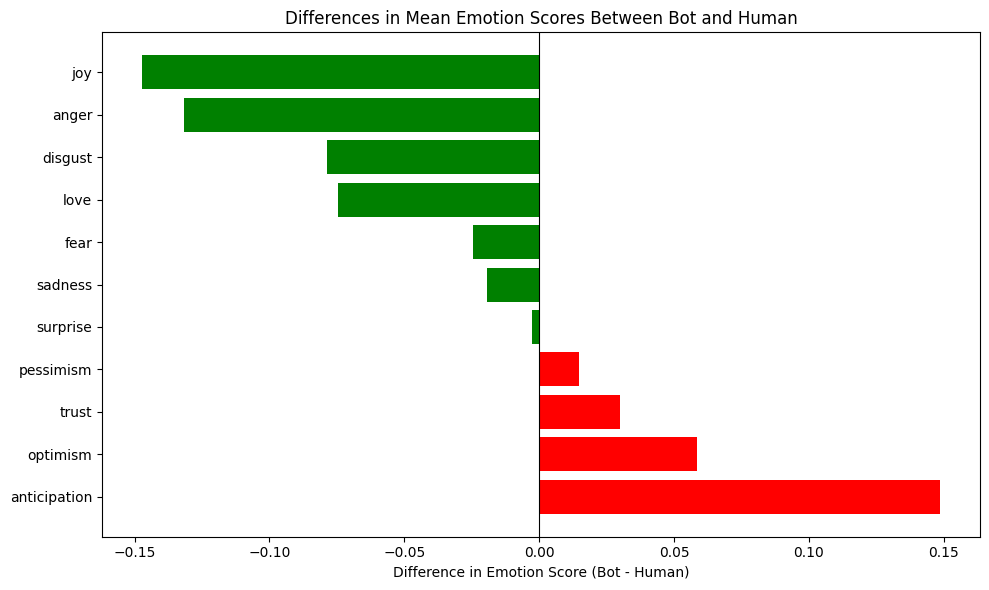

In [30]:
import numpy as np

def plot_emotion_differences(data, features, label_col='label'):
    """Plot differences in mean emotion scores between bot and human."""
    # calculate mean emotion scores by label
    means = data.groupby(label_col)[features].mean()
    
    # calculate the differences (bot - human)
    differences = means.loc[1] - means.loc[0]
    
    # sort emotions by the magnitude of differences
    differences = differences.sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    y = np.arange(len(differences))

    # plotting differences: negative (=more human) in green, positive (=more bot) in red
    ax.barh(y, differences, color=['red' if val > 0 else 'green' for val in differences], align='center')

    ax.set_yticks(y)
    ax.set_yticklabels(differences.index)
    ax.set_xlabel('Difference in Emotion Score (Bot - Human)')
    ax.set_title('Differences in Mean Emotion Scores Between Bot and Human')
    ax.axvline(0, color='black', linewidth=0.8)  # line to separate positive and negative

    plt.tight_layout()
    plt.show()

plot_emotion_differences(data, features, label_col='label')


Here the second approach where we group the emojis instead of transcribing them

In [21]:
import re

# Define positive, negative, and heart emoji groups
positive_emojis = [
    "😀", "😃", "😄", "😁", "😆", "😂", "🤣", "☺️", "😊", "😇", "🙂", "🙃", "😌", 
    "😍", "🥰", "😗", "😙", "😘", "😚", "😋", "😛", "😝", "😜", "🤪", "🤩", "🥳", 
    "🤗", "🤭", "👍"
]

negative_emojis = [
    "🤢", "🤮", "😥", "😰", "😭", "😢", "😖", "😣", "☹️", "🙁", "😕", "😟", "😔", 
    "😞", "👎", "💔"
]

heart_emojis = [
    "🫰", "🫶", "🩷", "❤️", "🧡", "💛", "💚", "🩵", "💙", "💜", "🖤", "🩶", "🤍", 
    "🤎", "❤️‍🔥", "❣️", "💕", "💞", "💓", "💗", "💖", "💘", "💝", "💟"
]

# Function to replace emoji with a category
def replace_emoji(match):
    emoji_char = match.group(0)
    # Check the emoji against the defined groups
    if emoji_char in positive_emojis:
        return "smiling_emoji"
    elif emoji_char in negative_emojis:
        return "sad_emoji"
    elif emoji_char in heart_emojis:
        return "heart"
    else:
        return "emoji"  # Default for any other emoji

def group_emojis(text):
    # define a regex pattern to match any emoji (by checking for Unicode emoji characters)
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # miscellaneous symbols and pictographs
        u'\U0001F680-\U0001F6FF'  # transport and map symbols
        u'\U0001F700-\U0001F77F'  # alchemical symbols
        u'\U0001F780-\U0001F7FF'  # geometric shapes
        u'\U0001F800-\U0001F8FF'  # supplemental arrows
        u'\U0001F900-\U0001F9FF'  # supplemental symbols and pictographs
        u'\U0001FA00-\U0001FA6F'  # chess symbols
        u'\U0001FA70-\U0001FAFF'  # symbols and pictographs
        u'\U00002702-\U000027B0'  # dingbats
        u'\U0001F004-\U0001F0CF'  # playing cards
        u'\U0001F201-\U0001F251'  # enclosed characters
        ']+', flags=re.UNICODE)
    
    # use regex to find all emojis in the text
    grouped_text = emoji_pattern.sub(replace_emoji, text)
    
    return grouped_text


In [22]:
# example usage
text = "I love programming 😊 but debugging 😢 can be tough! 🎉"
result = group_emojis(text)
print(result)


I love programming smiling_emoji but debugging sad_emoji can be tough! emoji


In [23]:
# apply emoji.demojize to the 'text' column
train_df['cleaned_text'] = train_df['removed_text'].apply(group_emojis)
test_df['cleaned_text'] = test_df['removed_text'].apply(group_emojis)
train_df.head()

,tweet,label,gender,removed_text,cleaned_text
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...
2,Check out these awesome cooking t-shirts &amp;...,bot,bot,check out these awesome cooking t-shi s &amp; ...,check out these awesome cooking t-shi s &amp; ...
3,YEWWinfo Tiny Nanoparticles to Treat a Huge Pr...,bot,bot,yewwinfo tiny nanopa icles to treat a huge pro...,yewwinfo tiny nanopa icles to treat a huge pro...
4,Sr. Project Manager Water / Wastewater Enginee...,bot,bot,sr. project manager water / wastewater enginee...,sr. project manager water / wastewater enginee...


In [24]:
# apply the classify_emotions function to the "cleaned_text" column
train_df["emotion_scores_new"] = train_df["cleaned_text"].apply(classify_emotions)
test_df["emotion_scores_new"] = test_df["cleaned_text"].apply(classify_emotions)

train_df

,tweet,label,gender,removed_text,cleaned_text,emotion_scores_new
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...,"[[{'label': 'anger', 'score': 0.98389005661010..."
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...,"[[{'label': 'anger', 'score': 0.35027897357940..."
2,Check out these awesome cooking t-shirts &amp;...,bot,bot,check out these awesome cooking t-shi s &amp; ...,check out these awesome cooking t-shi s &amp; ...,"[[{'label': 'anger', 'score': 0.22659523785114..."
3,YEWWinfo Tiny Nanoparticles to Treat a Huge Pr...,bot,bot,yewwinfo tiny nanopa icles to treat a huge pro...,yewwinfo tiny nanopa icles to treat a huge pro...,"[[{'label': 'anger', 'score': 0.57821470499038..."
4,Sr. Project Manager Water / Wastewater Enginee...,bot,bot,sr. project manager water / wastewater enginee...,sr. project manager water / wastewater enginee...,"[[{'label': 'anger', 'score': 0.79247719049453..."
...,...,...,...,...,...,...
295,"alchemy, conductor, clubhouse. http://t.co/ikj...",bot,bot,"alchemy, conductor, clubhouse. satchel, dispar...","alchemy, conductor, clubhouse. satchel, dispar...","[[{'label': 'anger', 'score': 0.02258552052080..."
296,An Unwelcome Reminder Puts Iran in Spotlight -...,bot,bot,an unwelcome reminder puts iran in spotlight -...,an unwelcome reminder puts iran in spotlight -...,"[[{'label': 'anger', 'score': 0.65255928039550..."
297,Principal Systems Engineer: Principal Systems ...,bot,bot,principal systems engineer: principal systems ...,principal systems engineer: principal systems ...,"[[{'label': 'anger', 'score': 0.01945850811898..."
298,Manufacturing Operators: Arconic Fastening Sys...,bot,bot,manufacturing operators: arconic fastening sys...,manufacturing operators: arconic fastening sys...,"[[{'label': 'anger', 'score': 0.01728037558495..."


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# function to parse emotion scores into individual columns
def extract_emotion_scores_new(df):
    def parse_scores(scores):
        if isinstance(scores, str):
            scores = eval(scores)  # convert string to list of lists
        scores = scores[0]  # flatten the structure
        return {item['label']: item['score'] for item in scores}
    
    emotion_data = pd.DataFrame(df['emotion_scores_new'].apply(parse_scores).tolist())
    df = pd.concat([df.reset_index(drop=True), emotion_data.reset_index(drop=True)], axis=1)
    return df

# prepare train and test datasets
emotion_train_df = extract_emotion_scores_new(train_df)
emotion_test_df = extract_emotion_scores_new(test_df)

# merge datasets for modeling
data = pd.concat([emotion_train_df, emotion_test_df], axis=0).reset_index(drop=True)

# encode label
label_map = {'human': 0, 'bot': 1}
data['label'] = data['label'].map(label_map)

# define features and target
features = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
X = data[features]
y = data['label']

# train-test split with random state 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=39),
    'Gradient Boosting': GradientBoostingClassifier(random_state=39),
    'SVM': SVC(probability=True, random_state=39)
}

# train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {model_name} ===")
    print(classification_report(y_test, y_pred))
    print("accuracy score: ",round(accuracy_score(y_test, y_pred),2))
    print()

    # store results
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        important_features = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        print(important_features.sort_values(by='Importance', ascending=False).head(5))
        print()

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        42
           1       0.65      0.63      0.64        38

    accuracy                           0.66        80
   macro avg       0.66      0.66      0.66        80
weighted avg       0.66      0.66      0.66        80

accuracy score:  0.66

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.76      0.60      0.67        42
           1       0.64      0.79      0.71        38

    accuracy                           0.69        80
   macro avg       0.70      0.69      0.69        80
weighted avg       0.70      0.69      0.69        80

accuracy score:  0.69

        Feature  Importance
4           joy    0.123118
1  anticipation    0.113146
0         anger    0.100870
5          love    0.093162
3          fear    0.090922

=== Gradient Boosting ===
              precision    recall  f1-score   support



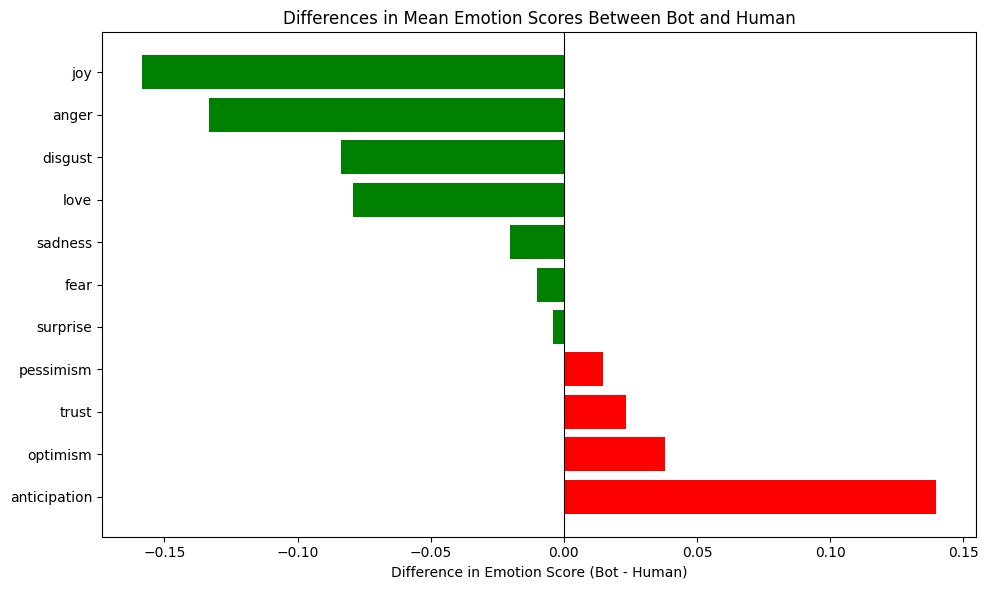

In [27]:
import numpy as np
def plot_emotion_differences(data, features, label_col='label'):
    """Plot differences in mean emotion scores between bot and human."""
    # calculate mean emotion scores by label
    means = data.groupby(label_col)[features].mean()
    
    # calculate the differences (bot - human)
    differences = means.loc[1] - means.loc[0]
    
    # sort emotions by the magnitude of differences
    differences = differences.sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    y = np.arange(len(differences))

    # plotting differences
    ax.barh(y, differences, color=['red' if val > 0 else 'green' for val in differences], align='center')

    ax.set_yticks(y)
    ax.set_yticklabels(differences.index)
    ax.set_xlabel('Difference in Emotion Score (Bot - Human)')
    ax.set_title('Differences in Mean Emotion Scores Between Bot and Human')
    ax.axvline(0, color='black', linewidth=0.8)  # Line to separate positive and negative

    plt.tight_layout()
    plt.show()

plot_emotion_differences(data, features, label_col='label')
